In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import theano
import theano.tensor as tt
import os
import utils
import make_data
from scipy.linalg import block_diag
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Settings

In [2]:
dz = 0.05
z_max = 3
z_arr = np.arange(0.0, z_max+0.1, dz)
a_arr = 1/(1+z_arr) 
x_arr = np.log(a_arr)

#z_max = 3
#res = 200
#x_arr = np.linspace(0, np.log(1+z_max), res)
#dx = np.mean(np.diff(x_arr))
#z_arr = np.exp(x_arr)-1
#a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products'


tools = utils.utils()
c = tools.c
data = make_data.make_data(z_max, len(z_arr) , path)


DESI = data.get_DESI(z_arr, new=True)
WFIRST = data.get_WFIRST(z_arr, new=True)
CC = data.get_CC(z_arr, new=True)
DSS = data.get_DSS(z_arr, new=True)
BOSS = data.get_BOSS(z_arr, new=True)
eBOSS = data.get_eBOSS(z_arr, new=True)
Wigglez = data.get_Wigglez(z_arr, new=True)
DS17 = data.get_DS17(z_arr, new=True)
#CMB = data.get_CMB(z_arr, new=True)
#FCMB = data.get_FCMB(new=True)

In [3]:
n_samples = 100
n_tune = 100
datadict = {'DESI': DESI,
            'WFIRST': WFIRST,
            'CC': CC,
            'DS17': DS17, 
            'BOSS': BOSS,
            'eBOSS': eBOSS,
            'Wigglez': Wigglez,
            'DSS': DSS}#,
            #'CMB': CMB}#, 
            #'FCMB': FCMB}

datasets = ['CC', 'BOSS']#, 'DSS', 'BOSS', 'eBOSS']

need_dM = ['DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DS17']
need_fs8 = ['DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DSS']
need_rd = ['BOSS', 'eBOSS', 'CMB']

use_species = False
use_poly = True

if any(dataset in datasets for dataset in need_dM):
    get_dM=True 
else:
    get_dM=False
    
if any(dataset in datasets for dataset in need_fs8):
    get_fs8=True
else:
    get_fs8=False
    
if any(dataset in datasets for dataset in need_rd):
    get_rd = True
else:
    get_rd = False

In [4]:
data = np.array([])
data_cov = np.array([])
for dataset_name in datasets:
    dataset = datadict[dataset_name]
    data = np.concatenate([data, dataset['data']])
    data_cov = block_diag(data_cov, dataset['cov'])
data_cov = data_cov [1:]

# Plotting

In [5]:
z_arr

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05])

In [6]:
np.arange(0.15, 1.85+0.1, 0.1)

array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15,
       1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85])

In [7]:
z_arr[DESI['idx']]

array([0.1 , 0.2 , 0.3 , 0.45, 0.5 , 0.6 , 0.75, 0.8 , 0.9 , 1.  , 1.1 ,
       1.2 , 1.3 , 1.4 , 1.5 , 1.6 , 1.7 , 1.8 ])

In [8]:
z_arr[CC['idx']]

array([0.05, 0.05, 0.1 , 0.15, 0.15, 0.15, 0.15, 0.25, 0.25, 0.35, 0.35,
       0.35, 0.35, 0.4 , 0.4 , 0.4 , 0.4 , 0.45, 0.45, 0.45, 0.5 , 0.55,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.85, 0.85, 0.85, 1.  , 1.25, 1.35,
       1.4 , 1.5 , 1.7 , 1.95, 2.3 , 2.35])

In [9]:
Planck = tools.get_preds(z_arr, mode='Planck')

In [10]:
Planck['Hkms_arr'][DESI['idx']]+(Planck['Hkms_arr'][DESI['idx']+1]-Planck['Hkms_arr'][DESI['idx']])*DESI['U']

array([ 72.20912549,  76.26245643,  80.76022843,  85.68125293,
        91.00282237,  96.70206215, 102.7568399 , 109.1463158 ,
       115.85122682, 122.85398763, 130.13867387, 137.69093602,
       145.49787689, 153.54791443, 161.83064307, 170.33670143,
       179.0576503 , 187.98586253])

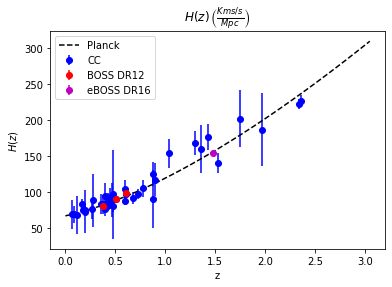

In [11]:
plt.plot(z_arr, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
#plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS DR16')


# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')  

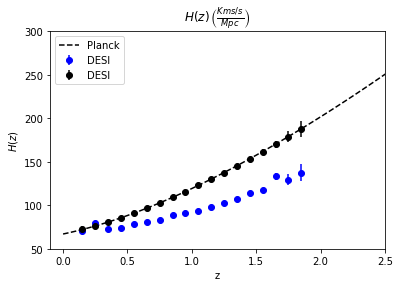

In [12]:
plt.plot(z_arr, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], DESI['H_data'], yerr = DESI['H_err'], fmt='bo', label='DESI')
plt.errorbar(DESI['z'], Planck['Hkms_arr'][DESI['idx']]+(Planck['Hkms_arr'][DESI['idx']+1]-Planck['Hkms_arr'][DESI['idx']])*DESI['U']
             , yerr = DESI['H_err'], fmt='ko', label='DESI')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')  

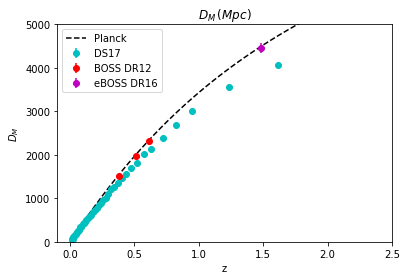

In [13]:
plt.plot(z_arr, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.2)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS DR16')

# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0, 5000)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')  

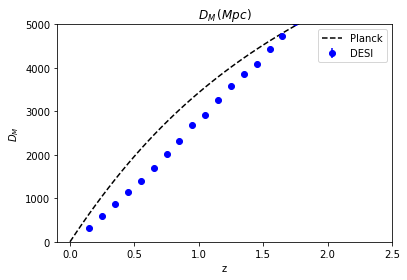

In [14]:
plt.plot(z_arr, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], (1+DESI['z'])*DESI['dA_data'], yerr=DESI['dA_err'], fmt='bo', label='DESI')

# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0, 5000)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')  

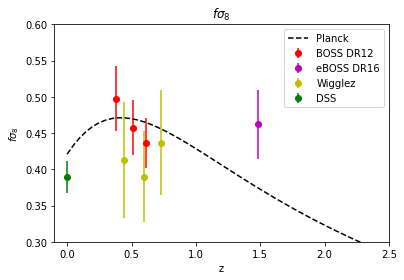

In [15]:
plt.plot(z_arr, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS DR16')
plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0.3, 0.6)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')  

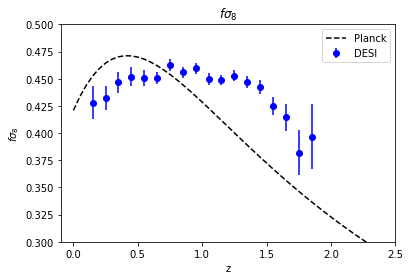

In [16]:
plt.plot(z_arr, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], DESI['fs8_data'], yerr=DESI['fs8_err'], fmt='bo', label='DESI')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0.3, 0.5)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')  

# Model

In [17]:
with pm.Model() as model:
    ℓ = pm.InverseGamma("ℓ", alpha=1, beta=2) 
    η = pm.HalfNormal("η", sigma=10) 
    gp_cov = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    wm0 = pm.Uniform("wm0", 0.1, 0.2)
    
    #Mean of the gp
    if use_species:
        print('Ussing species for expansion history')
        wL0 = pm.Uniform("wL0", 0.2, 0.4) 
        H = pm.Deterministic('H', 100*tt.sqrt(wm0*(1+z_arr)**3+wL0))
    if use_poly:
        print('Ussing polynomial fit for expansion history')
        H0 = pm.Normal('H0', mu=70 , sigma=5)
        H1 = pm.Normal('H1', mu=35 , sigma=5)
        H2 = pm.Normal('H2', mu=35 , sigma=5)
        H = pm.Deterministic('H_fit',
               tt.as_tensor_variable(H0+H1*z_arr+(1/2)*H2*z_arr**2))

    #Set up Gaussian process
    DH_gp = gp.prior("DH_gp", X=z_arr[:, None]) 
    H_gp = pm.Deterministic("H_gp", tt.as_tensor_variable(H+DH_gp))
    H0_gp = pm.Deterministic("H0_gp", tt.as_tensor_variable(H_gp[0]))
    
    if get_dM:
        dH_gp = pm.Deterministic("dH", tt.as_tensor_variable((c/1000)/H_gp))
        dM_gp = tt.zeros(len(z_arr))
        dM_gp = tt.inc_subtensor(dM_gp[1:],
                  tt.as_tensor_variable(dz*tt.cumsum(dH_gp))[:-1])
        dM_gp = pm.Deterministic('dM_gp', dM_gp)
        dA_gp = pm.Deterministic('dA_gp', dM_gp/(1+z_arr))
        dL_gp = pm.Deterministic('dL_gp', dM_gp*(1+z_arr))
        
    if get_rd:
        wb0 = pm.Normal("wb0", 0.02226, sigma=0.00023)
        theta27 = 2.755/2.7 
        zeq =  2.5 * 10**4 * wm0 * theta27**-4 
        keq = 7.46 * 10**-2 * wm0 * theta27**-2
        b1 = 0.313 * wm0**(-0.419) * (1 + 0.607 * wm0**(0.674))
        b2 = 0.238 * wm0**(0.223)
        zd = 1291 * ((wm0**0.251)/(1+0.659*wm0**0.828)) * (1+ b1*wb0**b2)
        Rd = 31.5 * wb0 * theta27**-4 * (zd/10*3)**-1
        Req = 31.5 * wb0 * theta27**-4 * (zeq/10*3)**-1
        rd_gp = pm.Deterministic('rd_gp',(2/(3*keq))*tt.sqrt(6/Req)*tt.log((tt.sqrt(1+Rd)+tt.sqrt(Rd+Req))/(1+tt.sqrt(Req))))
        
    if get_fs8:
        #Second order differentiation scheme
        Wm =  pm.Deterministic("Wm", wm0*(100/H_gp)**2*(1+z_arr)**3)
        Df = pm.Uniform("Df", 0.04, 0.06)
        s80 = pm.Normal("s80", 0.8, 0.5)
        comf_H = pm.Deterministic("comf_H", a_arr*H_gp)
        diff_comf_H = tt.zeros(len(z_arr))
        diff_comf_H = tt.inc_subtensor(diff_comf_H[0], (comf_H[1]-comf_H[0])/(x_arr[1]-x_arr[0]))
        diff_comf_H = tt.inc_subtensor(diff_comf_H[1:-1], (comf_H[2:]-comf_H[:-2])/(x_arr[2:]-x_arr[:-2]))
        diff_comf_H = tt.inc_subtensor(diff_comf_H[-1], (comf_H[-1]-comf_H[-2])/(x_arr[-1]-x_arr[-2]))
        diff_comf_H  = pm.Deterministic("diff_comf_H", diff_comf_H)
        q = 1+(diff_comf_H/comf_H)


        #Implement second Order Runge-Kutta method
        f0 = pm.Deterministic('f0', 1-Df) 
        f_gp = tt.zeros(len(z_arr))
        f_gp = tt.inc_subtensor(f_gp[-1], f0)
        for i in np.arange(1, len(z_arr)):
            k0 = (-1/(1+z_arr[-i]))*((3/2)*Wm[-i]-f_gp[-i]**2-q[-i]*f_gp[-i])
            f1 = f_gp[-i]-dz*k0
            k1 = (-1/(1+z_arr[-(i+1)]))*((3/2)*Wm[-(i+1)]-f1**2-q[-(i+1)]*f1)
            f_gp = tt.inc_subtensor(f_gp[-(i+1)], f_gp[-i]-dz*(k1+k0)/2)
        f_gp = pm.Deterministic("f_gp", f_gp) 

        #integrate for s8 method2
        s8_gp = tt.zeros(len(z_arr))
        s8_gp = tt.inc_subtensor(s8_gp[0], s80)
        for i in np.arange(1, len(z_arr)):
            k0 = -1*(f_gp[i-1]*s8_gp[i-1])/(1+z_arr[i-1])
            s8_gp = tt.inc_subtensor(s8_gp[i], s8_gp[i-1] + dz*(k0))
        s8_gp = pm.Deterministic("s8_gp", s8_gp) 

        fs8_gp = f_gp*s8_gp
        fs8_gp = pm.Deterministic("fs8_gp", fs8_gp)
    
    theory = tt.as_tensor_variable([])

Ussing polynomial fit for expansion history


In [18]:
if 'DESI' in datasets:
    print('Adding DESI')
    with model:
        DESI_H = pm.Deterministic('DESI_H',
                 tt.as_tensor_variable(H_gp[DESI['idx']]+(H_gp[DESI['idx']+1]-H_arr[DESI['idx']])*DESI['U']))
        DESI_dA = pm.Deterministic('DESI_dA',
                  tt.as_tensor_variable(dA_gp[DESI['idx']]+(dA_gp[DESI['idx']+1]-dA_gp[DESI['idx']])*DESI['U']))
        DESI_fs8 = pm.Deterministic('DESI_fs8',
                   tt.as_tensor_variable(fs8_gp[DESI['idx']]+(fs8_gp[DESI['idx']+1]-fs8_gp[DESI['idx']])*DESI['U']))
        theory = tt.concatenate([theory, DESI_H, DESI_dA, DESI_fs8])
        
if 'WFIRST' in datasets:
    print('Adding WFIRST')
    with model:
        WFIRST_E = pm.Deterministic('WFIRST_E',
                   tt.as_tensor_variable(E_gp[WFIRST['idx']]+(E_gp[WFIRST['idx']+1]-E_gp[WFIRST['idx']])*WFIRST['U']))
        theory = tt.concatenate([theory, WFIRST_E])

if 'CC' in datasets:
    print('Adding CCs')
    with model:
        CC_H = pm.Deterministic("CC_H",
               tt.as_tensor_variable(H_gp[CC['idx']]+(H_gp[CC['idx']+1]-H_gp[CC['idx']])*CC['U']))
        theory = tt.concatenate([theory, CC_H])
        
if 'DS17' in datasets:
    print('Adding Pantheon')
    with model:
        M = pm.Normal('M', mu=-19.0, sigma=1)
        u_gp = pm.Deterministic('u_gp', tt.as_tensor_variable(5*tt.log10(dL_gp)+25+M))
        DS17_u = pm.Deterministic("DS17_u",
                 tt.as_tensor_variable(u_gp[DS17['idx']]+(u_gp[DS17['idx']+1]-u_gp[DS17['idx']])*DS17['U']))
        theory = tt.concatenate([theory, DS17_u])
        
if 'BOSS' in datasets:
    print('Adding BOSS')
    with model:
        #Get alpha_perp and alpha_para 
        B_para_f = pm.Deterministic("B_para_f", H_gp*rd_gp/BOSS['rd'])
        B_perp_f = pm.Deterministic("B_perp_f", dM_gp*BOSS['rd']/rd_gp)
        
        B_para = pm.Deterministic("B_para", 
                    tt.as_tensor_variable(B_para_f[BOSS['idx']]+(B_para_f[BOSS['idx']+1]-B_para_f[BOSS['idx']])*BOSS['U']))
        B_perp = pm.Deterministic("B_perp", 
                tt.as_tensor_variable(B_perp_f[BOSS['idx']]+(B_perp_f[BOSS['idx']+1]-B_perp_f[BOSS['idx']])*BOSS['U']))
        B_fs8 = pm.Deterministic("B_fs8", 
                   tt.as_tensor_variable(fs8_gp[BOSS['idx']]+(fs8_gp[BOSS['idx']+1]-fs8_gp[BOSS['idx']])*BOSS['U']))
        
        theory = tt.concatenate([theory, B_para, B_perp, B_fs8])
        
if 'eBOSS' in datasets:
    print('Adding eBOSS')
    with model:
        eB_para_f = pm.Deterministic("eB_para_f", dH_gp/rd_gp)
        eB_perp_f = pm.Deterministic("eB_perp_f", dM_gp/rd_gp)
        
        eB_para = pm.Deterministic("eB_para", 
                    tt.as_tensor_variable(eB_para_f[eBOSS['idx']]+(eB_para_f[eBOSS['idx']+1]-eB_para_f[eBOSS['idx']])*eBOSS['U']))
        eB_perp = pm.Deterministic("eB_perp", 
                tt.as_tensor_variable(eB_perp_f[eBOSS['idx']]+(eB_perp_f[BOSS['idx']+1]-eB_perp_f[eBOSS['idx']])*eBOSS['U']))
        eB_fs8 = pm.Deterministic("eB_fs8", 
                   tt.as_tensor_variable(fs8_gp[eBOSS['idx']]+(fs8_gp[eBOSS['idx']+1]-fs8_gp[eBOSS['idx']])*eBOSS['U']))
        
        theory = tt.concatenate([theory, eB_para, eB_perp, eB_fs8])

if 'Wigglez' in datasets:
    print('Adding Wigglez')
    with model:
        Wigglez_fs8 = pm.Deterministic("Wigglez_fs8",
                    tt.as_tensor_variable(fs8_gp[Wigglez['idx']]+(fs8_gp[Wigglez['idx']+1]-fs8_gp[Wigglez['idx']])*Wigglez['U']))
        theory = tt.concatenate([theory, Wigglez_fs8])

if 'DSS' in datasets:
    print('Adding DSS')
    with model:
        DSS_fs8 = pm.Deterministic("fs8_eBOSS", tt.as_tensor_variable(fs8_gp[DSS['idx']]))
        theory = tt.concatenate([theory, DSS_fs8])

if 'CMB' in datasets:
    print('Adding CMB')
    with model:
        CMB_dM = pm.Deterministic('CMB_dM',
                  tt.as_tensor_variable(dM_gp[CMB['idx']]+(dM_gp[CMB['idx']+1]-dM_gp[CMB['idx']])*CMB['U']))
        t100 = pm.Deterministic("theta100", tt.as_tensor_variable(100*rd_gp/CMB_dM))
        theory = tt.concatenate([theory, theta100])
        
if 'FCMB' in datasets:
    print('Adding FCMB')
    with model:
        CMB_H = pm.Deterministic('CMB_H',
                  tt.as_tensor_variable(H_gp[FCMB['idx']]+(H_gp[FCMB['idx']+1]-H_gp[FCMB['idx']])*FCMB['U']))
        theory = tt.concatenate([theory, CMB_H])
        
with model:
    lkl= pm.MvNormal("lkl", mu=theory, cov=data_cov, observed=data)
    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune)


Adding CCs
Adding BOSS


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: array must not contain infs or NaNs
Apply node that caused the error: Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}(TensorConstant{[[1.960000..1606e-02]]}, Elemwise{Sub}[(0, 1)].0)
Toposort index: 677
Inputs types: [TensorType(float64, matrix), TensorType(float64, col)]
Inputs shapes: [(48, 48), (48, 1)]
Inputs strides: [(8, 384), (8, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[InplaceDimShuffle{1,0}(Solve{A_structure='lower_triangular', lower=False, overwrite_A=False, overwrite_b=False}.0)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/distributions/distribution.py", line 122, in __new__
    return model.Var(name, dist, data, total_size, dims=dims)
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/model.py", line 1177, in Var
    var = ObservedRV(
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/model.py", line 1831, in __init__
    self.logp_sum_unscaledt = distribution.logp_sum(data)
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/distributions/distribution.py", line 267, in logp_sum
    return tt.sum(self.logp(*args, **kwargs))
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/distributions/multivariate.py", line 307, in logp
    quaddist, logdet, ok = self._quaddist(value)
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/distributions/multivariate.py", line 128, in _quaddist
    dist, logdet, ok = self._quaddist_cov(delta)
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/distributions/multivariate.py", line 153, in _quaddist_cov
    return self._quaddist_chol(delta)
  File "/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/distributions/multivariate.py", line 147, in _quaddist_chol
    delta_trans = self.solve_lower(chol_cov, delta.T).T

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
pm.summary(trace)['r_hat'][["ℓ","η"]]

In [ ]:
pm.summary(trace)['mean'][["ℓ","η"]]

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["DH_gp"][0, :, :], z_arr[:, None])

# axis labels and title
plt.xlabel("z")
plt.ylabel("DH(z)")
plt.title("DH(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
ax.plot(z_arr[:, None], Planck['Hkms_arr'], "k--", label=r'$LCDM$')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'FCMB' in datasets:
    plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')


# axis labels and title
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
ax.plot(z_arr[:, None], Planck['Hkms_arr'], "k--", label=r'$LCDM$')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'FCMB' in datasets:
    plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')


# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dM_gp"][0, :, :][:,:len_l],
             z_arr[:, None][:len_l])

plt.plot(z_arr_l, Planck['dM_arr'], "k--", label='Planck')
if 'DS17' in datasets:
    plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.49)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS')
#if 'CMB' in datasets:
#    plt.errorbar(CMB['z'], 100*CMB['rd']/CMB['data'], yerr=1/CMB['err'], fmt='mo', label='eBOSS')

# axis labels and title

plt.xlabel("z")
plt.ylabel("dM(z)")
plt.title("dM(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp"][0, :, :][:,:len_l],
             z_arr[:, None][:len_l])

plt.plot(z_arr_l, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS')
if 'Wigglez' in datasets:
    plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
if 'DSS' in datasets:
    plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')


# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["s8_gp"])[0, :, :][:,:len_l],
             z_arr[:, None][:len_l])

# plot the data and the true latent function
ax.plot(z_arr_l[:, None], Planck['s8_arr'], "k--", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("sigma8(z)")
plt.title("sigma8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["f_gp"])[0, :, :][:,:len_l],
             z_arr[:, None][:len_l])

# plot the data and the true latent function
ax.plot(z_arr_l[:, None], Planck['f_arr'], "k--", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f(z)")
plt.legend();


In [ ]:
filename = ''
for dataset in datasets:
    filename+=dataset+'_'
path = filename+'{}_{}'.format(n_samples, n_tune)

n = np.array(trace.posterior["η"]).flatten()
l = np.array(trace.posterior["ℓ"]).flatten()
DHz = np.array(trace.posterior["DH_gp"])
DHz = DHz.reshape(-1, DHz.shape[-1])
Hz =np.array(trace.posterior["H_gp"])
Hz = Hz.reshape(-1, Hz.shape[-1])
H0 = np.array(trace.posterior["H0_gp"]).flatten()

if get_dM:
    dMz = np.array(trace.posterior["dM_gp"])
    dMz = dMz.reshape(-1, dMz.shape[-1])
else:
    dMz = None
    
if get_fs8:
    fz = np.array(trace.posterior["f_gp"])
    fz= fz.reshape(-1, fz.shape[-1])
    s8z = np.array(trace.posterior["s8_gp"])
    s8z = s8z.reshape(-1, s8z.shape[-1])
    fs8z = np.array(trace.posterior["fs8_gp"])
    fs8z = fs8z.reshape(-1, fs8z.shape[-1])
    Omega_m = np.array(trace.posterior["Wm0"]).flatten()
    s80 = np.array(trace.posterior["s80"]).flatten()
    S80 = s80*np.sqrt(Omega_m/0.3)
    if 'CMB' not in datasets:
        Df = np.array(trace.posterior["Df"]).flatten()
else:
    fz = None  
    s8z = None 
    fs8z = None
    Omega_m = None 
    s80 = None
    S80 = None
    Df = None

if 'BOSS' in datasets:
    Omega_b = np.array(trace.posterior["Wb0"]).flatten()
    rd = np.array(trace.posterior["rd_gp"]).flatten()
else:
    Omega_b = None
    rd = None

if 'DS17' in datasets:
    M = np.array(trace.posterior["M"]).flatten()
else:
    M = None

os.mkdir(path)
np.savez(os.path.join(path,'samples.npz'), 
         z_arr = z_arr,
         n=n,
         l=l,
         DHz = DHz,
         Hz=Hz,
         dMz=dMz,
         fz=fz,
         s8z=s8z,
         fs8z=fs8z,
         H0=H0,
         Omega_m=Omega_m,
         Omega_b=Omega_b,
         s80=s80,
         S80=S80, 
         rd=rd,
         Df=Df,
         M=M)